## Random forest

In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    mean_absolute_percentage_error,
    r2_score,
    explained_variance_score
)
import plotly.graph_objects as go

SEED = 42
np.random.seed(SEED)

# === 1. Download Brent crude oil price data ==================================
df = (
    yf.download("BZ=F", start="2011-06-13", end="2025-06-25")[['Close']]
      .rename(columns={'Close': 'Price'})
      .dropna()
)

# === 2. Load & align embeddings =============================================
emb = (
    pd.read_csv('../Data/raw/embeddings_feature_distilbert-base-uncased.csv', parse_dates=['date'])
      .set_index('date')
)
# Rialliniamo all'indice di df
emb = emb.reindex(df.index).ffill().bfill()

sent = (
    pd.read_csv('../Data/raw/daily_sent.csv', parse_dates=['Date'])
      .set_index('Date')
)

# Aggiungiamo gli embedding al DataFrame principale

df['SENT_1'] = emb['embedding_2d_1_mean']
df['SENT_2'] = emb['embedding_2d_2_mean']
df['cosine_sim']            = emb['cosine_sim']
df['drift']                 = emb['drift']
df['drift_velocity']        = emb['drift_velocity']
df['drift_velocity_diff']   = emb['drift_velocity_diff']
df['drift_acceleration']    = emb['drift_acceleration']
df['var_2d_1']              = emb['embedding_2d_1_var_daily']
df['var_2d_2']              = emb['embedding_2d_2_var_daily']
df['sentiment']             = sent['avg_score']

# === 3. Costruzione delle lag-feature =======================================
# Lag dei prezzi
for lag in range(1, 6):
    df[f'price_lag_{lag}'] = df['Price'].shift(lag)



# Target = prezzo del giorno successivo
df['target'] = df['Price'].shift(-1)
df.dropna(inplace=True)

# === 4. Train-test split (90/10) ============================================

feat_cols = [
    'Price',
    'SENT_1','SENT_2',
    'cosine_sim','drift','drift_velocity','drift_velocity_diff','drift_acceleration',
    'var_2d_1','var_2d_2',
    'sentiment'
]

X = df[feat_cols]
y = df['target']
split_idx = int(len(df) * 0.9)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

# === 5. Train Random Forest =================================================
rf = RandomForestRegressor(n_estimators=200, random_state=SEED, n_jobs=-1)
rf.fit(X_train, y_train)
preds = rf.predict(X_test)

# === 6. Metriche di valutazione ============================================
def smape(y_true, y_pred):
    denom = (np.abs(y_true) + np.abs(y_pred)) / 2
    return np.mean(np.abs(y_true - y_pred) / denom) * 100

def theils_u(y_true, y_pred):
    rmsfe = np.sqrt(np.mean((y_pred - y_true) ** 2))
    denom = (np.sqrt(np.mean(y_true ** 2)) +
             np.sqrt(np.mean(y_pred ** 2)))
    return rmsfe / denom

metrics = {
    "RMSE": np.sqrt(mean_squared_error(y_test, preds)),
    "MAE": mean_absolute_error(y_test, preds),
    "MAPE (%)": mean_absolute_percentage_error(y_test, preds) * 100,
    "sMAPE (%)": smape(y_test.values, preds),
    "R²": r2_score(y_test, preds),
    "Explained Variance": explained_variance_score(y_test, preds),
    "Theil’s U": theils_u(y_test.values, preds),
    "Directional Accuracy (%)": (
        np.mean(
            np.sign(y_test.values[1:] - y_test.values[:-1]) ==
            np.sign(preds[1:] - y_test.values[:-1])
        ) * 100
    )
}

print(pd.Series(metrics).to_frame('Random Forest').round(4))

# === 7. Grafico Plotly Actual vs Predicted =================================
fig = go.Figure()
fig.add_trace(go.Scatter(
    x=y_test.index, y=y_test, mode='lines', name='Actual'
))
fig.add_trace(go.Scatter(
    x=y_test.index, y=preds, mode='lines', name='Predicted'
))
fig.update_layout(
    title='Brent Crude Oil – Actual vs Predicted',
    xaxis_title='Date',
    yaxis_title='Price (USD)',
    template='plotly_white',
    legend=dict(orientation='h', y=-0.2)
)
fig.show()


[*********************100%***********************]  1 of 1 completed


                          Random Forest
RMSE                             1.5681
MAE                              1.1689
MAPE (%)                         1.5471
sMAPE (%)                        1.5432
R²                               0.9515
Explained Variance               0.9516
Theil’s U                        0.0102
Directional Accuracy (%)        51.9288


/opt/homebrew/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning:

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html



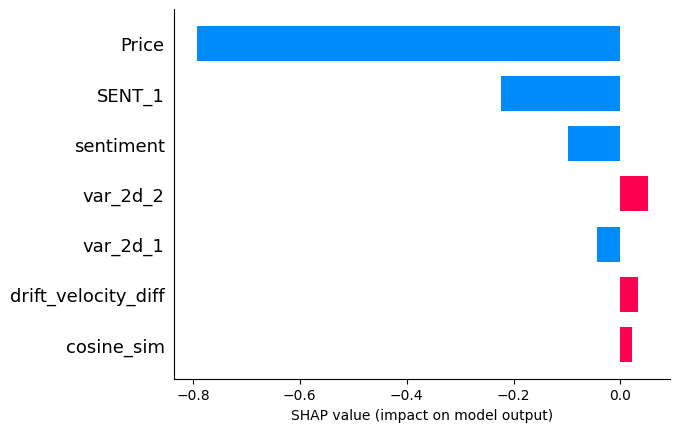

In [3]:
import shap

explainer = shap.TreeExplainer(rf)

def shap_bar_plot_for_date(date_str):
    date = pd.to_datetime(date_str)
    if date not in X_test.index:
        print(f"Data {date_str} non trovata nel test set.")
        return

    x_instance = X_test.loc[date].values.reshape(1, -1)
    shap_values = explainer.shap_values(x_instance)

    shap.bar_plot(shap_values[0], feature_names=feat_cols)

shap_bar_plot_for_date("2025-04-02")

In [4]:
df.loc['2025-04-02', ['Price', 'target']]

Price   Ticker
Price   BZ=F      74.949997
target            70.139999
Name: 2025-04-02 00:00:00, dtype: float64

In [5]:
date_target = '2025-04-03'
idx = y_test.index.get_loc(date_target)
preds[idx]

70.08345050811768

In [7]:
import pandas as pd

df_1 = pd.read_csv("../Data/raw/embeddings_CA_dBert.csv")
df_1.drop(columns=['Unnamed: 0'], inplace=True)
df_1[df_1["Date"] == "2025-04-02"]["cluster"]

645    15
646     8
647     8
648     3
649    12
650     0
651     3
652     3
653    16
654     3
655     3
656    11
Name: cluster, dtype: int64

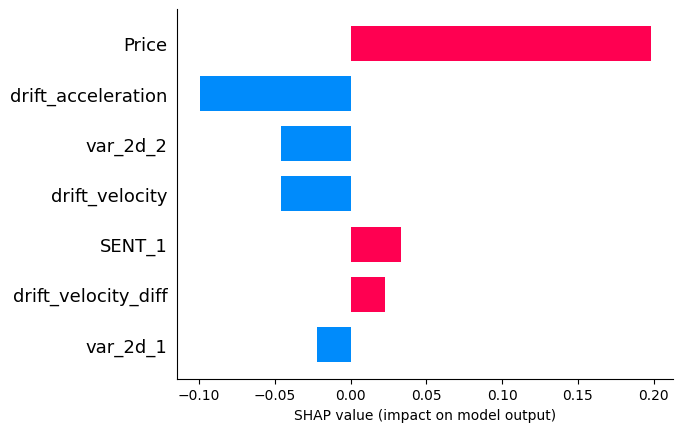

In [8]:
explainer = shap.TreeExplainer(rf)

def shap_bar_plot_for_date(date_str):
    date = pd.to_datetime(date_str)
    if date not in X_test.index:
        print(f"Data {date_str} non trovata nel test set.")
        return

    x_instance = X_test.loc[date].values.reshape(1, -1)
    shap_values = explainer.shap_values(x_instance)

    shap.bar_plot(shap_values[0], feature_names=feat_cols)

shap_bar_plot_for_date("2025-06-17")

In [9]:
df.loc['2025-06-17', ['Price', 'target']]

Price   Ticker
Price   BZ=F      76.449997
target            76.699997
Name: 2025-06-17 00:00:00, dtype: float64

In [10]:
date_target = '2025-06-18'
idx = y_test.index.get_loc(date_target)
preds[idx]


76.381650390625

In [11]:
df_1 = pd.read_csv("../Data/raw/embeddings_CA_ST.csv")
df_1.drop(columns=['Unnamed: 0'], inplace=True)
df_1[df_1["Date"] == "2025-06-17"]["cluster"]

60     9
61     4
62    13
63     6
64    11
65     0
66     8
67    11
68    13
69     2
70    13
Name: cluster, dtype: int64

## XGBOOST

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    mean_absolute_percentage_error,
    r2_score,
    explained_variance_score
)
import plotly.graph_objects as go

SEED = 42
np.random.seed(SEED)

# === 1. Download Brent crude oil price data ==================================
df = (
    yf.download("BZ=F", start="2011-06-13", end="2025-06-25")[['Close']]
      .rename(columns={'Close': 'Price'})
      .dropna()
)

# === 2. Load & align embeddings =============================================
emb = (
    pd.read_csv('../Data/raw/embeddings_feature_distilbert-base-uncased.csv', parse_dates=['date'])
      .set_index('date')
)
emb = emb.reindex(df.index).ffill().bfill()
sent = (
    pd.read_csv('../Data/raw/daily_sent.csv', parse_dates=['Date'])
      .set_index('Date')
)

df['SENT_1'] = emb['embedding_3d_1_mean']
df['SENT_2'] = emb['embedding_3d_2_mean']
df['SENT_3'] = emb['embedding_3d_3_mean']
df['cosine_sim']            = emb['cosine_sim']
df['drift']                 = emb['drift']
df['drift_velocity']        = emb['drift_velocity']
df['drift_velocity_diff']   = emb['drift_velocity_diff']
df['drift_acceleration']    = emb['drift_acceleration']
df['var_3d_1']              = emb['embedding_3d_1_var_daily']
df['var_3d_2']              = emb['embedding_3d_2_var_daily']
df['var_3d_3']              = emb['embedding_3d_3_var_daily']
df['sentiment']             = sent['avg_score']

# === 3. Costruzione delle lag-feature =======================================
for lag in range(1, 6):
    df[f'price_lag_{lag}'] = df['Price'].shift(lag)

df['target'] = df['Price'].shift(-1)
df.dropna(inplace=True)

# === 4. Train-test split (90/10) ============================================
feat_cols = [
    'Price',
    'SENT_1','SENT_2','SENT_3',
    'cosine_sim','drift','drift_velocity','drift_velocity_diff','drift_acceleration',
    'var_3d_1','var_3d_2','var_3d_3',
    'sentiment'
]

X = df[feat_cols]
y = df['target']
split_idx = int(len(df) * 0.9)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

# === 5. Train XGBoost ======================================================
xgb = XGBRegressor(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.07,
    subsample=0.9,
    colsample_bytree=0.9,
    random_state=SEED,
    n_jobs=-1,
    tree_method="hist"  # "gpu_hist" se hai una GPU
)
xgb.fit(X_train, y_train)
preds = xgb.predict(X_test)

# === 6. Metriche di valutazione ============================================
def smape(y_true, y_pred):
    denom = (np.abs(y_true) + np.abs(y_pred)) / 2
    return np.mean(np.abs(y_true - y_pred) / denom) * 100

def theils_u(y_true, y_pred):
    rmsfe = np.sqrt(np.mean((y_pred - y_true) ** 2))
    denom = (np.sqrt(np.mean(y_true ** 2)) +
             np.sqrt(np.mean(y_pred ** 2)))
    return rmsfe / denom

metrics = {
    "RMSE": np.sqrt(mean_squared_error(y_test, preds)),
    "MAE": mean_absolute_error(y_test, preds),
    "MAPE (%)": mean_absolute_percentage_error(y_test, preds) * 100,
    "sMAPE (%)": smape(y_test.values, preds),
    "R²": r2_score(y_test, preds),
    "Explained Variance": explained_variance_score(y_test, preds),
    "Theil’s U": theils_u(y_test.values, preds),
    "Directional Accuracy (%)": (
        np.mean(
            np.sign(y_test.values[1:] - y_test.values[:-1]) ==
            np.sign(preds[1:] - y_test.values[:-1])
        ) * 100
    )
}

print(pd.Series(metrics).to_frame('XGBoost').round(4))

# === 7. Grafico Plotly Actual vs Predicted =================================
fig = go.Figure()
fig.add_trace(go.Scatter(
    x=y_test.index, y=y_test, mode='lines', name='Actual'
))
fig.add_trace(go.Scatter(
    x=y_test.index, y=preds, mode='lines', name='Predicted'
))
fig.update_layout(
    title='Brent Crude Oil – Actual vs Predicted (XGBoost)',
    xaxis_title='Date',
    yaxis_title='Price (USD)',
    template='plotly_white',
    legend=dict(orientation='h', y=-0.2)
)
fig.show()


[*********************100%***********************]  1 of 1 completed


                          XGBoost
RMSE                       1.7188
MAE                        1.2609
MAPE (%)                   1.6570
sMAPE (%)                  1.6508
R²                         0.9417
Explained Variance         0.9422
Theil’s U                  0.0111
Directional Accuracy (%)  53.7092
